In [1]:
from google.colab import drive
drive.mount('/b05501039@g.ntu.edu.tw/')  #登入google帳戶以讀存取資料

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wH0JOsWKa6C-pzSeNNrfju-DYgOlEidckP7aezzMiHnFd90h-Ms-sY
Mounted at /b05501039@g.ntu.edu.tw/


In [2]:
%tensorflow_version 1.x  #切換tf版本(colab指令)
import tensorflow as tf
gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name) #確定device name
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess) #查看使用中的GPU

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  #切換tf版本(colab指令)`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
/device:GPU:0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adam
from keras.layers import LSTM, Activation, CuDNNLSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.externals import joblib  # save scaler
import time
from random import shuffle
import os

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
def ScalingInput(train,test):
    train_flatten = np.reshape(train, [train.shape[0]*train.shape[1]*train.shape[2],1])  
    test_flatten = np.reshape(test, [test.shape[0]*test.shape[1]*test.shape[2],1]) 
    scaler_X = MinMaxScaler(feature_range=(-1, 1))  #標準化器
    scaler_X.fit(train_flatten)  #對應到要縮放的資料
    train_flatten_map = scaler_X.transform(train_flatten)  
    train_map = np.reshape(train_flatten_map, [train.shape[0], train.shape[1], train.shape[2]]) 
    test_flatten_map = scaler_X.transform(test_flatten)  
    test_map = np.reshape(test_flatten_map, [test.shape[0], test.shape[1], test.shape[2]]) 
    return train_map, test_map, scaler_X
 
def ScalingOutput(train,test):
    train_flatten = np.reshape(train, [train.shape[0]*train.shape[1] ,train.shape[2]])  
    test_flatten = np.reshape(test, [test.shape[0]*test.shape[1], test.shape[2]]) 
    scaler_y = MinMaxScaler(feature_range=(-1, 1))  #標準化器
    scaler_y.fit(train_flatten)  #對應到要縮放的資料
    train_flatten_map = scaler_y.transform(train_flatten)  
    train_map = np.reshape(train_flatten_map, [train.shape[0], train.shape[1], train.shape[2]]) 
    test_flatten_map = scaler_y.transform(test_flatten)  
    test_map = np.reshape(test_flatten_map, [test.shape[0], test.shape[1], test.shape[2]]) 
    return train_map, test_map, scaler_y
    
def prediction(X_scale_stack,y_scale_stack,scaler_y_Disp):
  pred = model.predict(X_scale_stack) 
  pred_flatten = np.reshape(pred, [pred.shape[0]*pred.shape[1], pred.shape[2]])  
  pred = scaler_y_Disp.inverse_transform(pred_flatten)  #將預測數值縮放回原大小 
  pred = np.reshape(pred, [y_scale_stack.shape[0], y_scale_stack.shape[1], y_scale_stack.shape[2]])  
  return pred

def MSE(Response_true,Response_pred):
  ErrorList=[]
  for i in range(Response_true.shape[0]):
      for k in range(Response_true.shape[2]):
        true_std = (Response_true[i,:,k] - Response_true[i,:,k].min()) / (Response_true[i,:,k].max() - Response_true[i,:,k].min())
        true_scaled = true_std * (1-(-1)) + (-1)
        pred_std = (Response_pred[i,:,k] - Response_true[i,:,k].min()) / (Response_true[i,:,k].max() - Response_true[i,:,k].min())
        pred_scaled = pred_std * (1-(-1)) + (-1)

        ErrorList.append( sum((pred_scaled- true_scaled)**2)/Response_true.shape[1] ) 
  Mse = np.array(ErrorList).reshape(Response_true.shape[0],Response_true.shape[2])
  return Mse


In [5]:
#-------------------------------------------------------------------------------
# Load training data and validation data
dataDir = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.2g_Earthquake/' 
resultDir = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.2g_Earthquake/Disp/0.2gDisp10/'  
mat_data = scipy.io.loadmat(dataDir+'NewData_Disp_BC_Cluster.mat')

# original data
X_train_stack = mat_data['X_train_stack']
y_Disp_train_stack = mat_data['y_Disp_train_stack']
X_test_stack = mat_data['X_test_stack']
y_Disp_test_stack = mat_data['y_Disp_test_stack']
X_test_stack_c0 = mat_data['X_test_stack_c0']
y_Disp_test_stack_c0 = mat_data['y_Disp_test_stack_c0']


# original data
X_train_scale_stack, X_test_scale_stack, scaler_X = ScalingInput(X_train_stack,X_test_stack)
X_train_scale_stack, X_test_scale_stack_c0, scaler_X_c0 = ScalingInput(X_train_stack,X_test_stack_c0)

y_Disp_train_scale_stack, y_Disp_test_scale_stack, scaler_y_Disp = ScalingOutput(y_Disp_train_stack,y_Disp_test_stack)
y_Disp_train_scale_stack, y_Disp_test_scale_stack_c0, scaler_y_Disp_c0 = ScalingOutput(y_Disp_train_stack,y_Disp_test_stack_c0)


# earthquake
name_train = mat_data['name_train']
name_test = mat_data['name_test']
name_test_c0 = mat_data['name_test_c0']
steps_train = mat_data['steps_train']
steps_test = mat_data['steps_test']
steps_test_c0 = mat_data['steps_test_c0']

model = load_model(resultDir+'best_model.h5')
'''scaler_X = joblib.load(dataDir+'scaler_X.save')
scaler_y = joblib.load(dataDir+'scaler_y_Acc.save')'''
# Predict Training data and Testing data  
y_Disp_train_stack_pred = prediction(X_train_scale_stack,y_Disp_train_scale_stack,scaler_y_Disp)
y_Disp_test_stack_pred = prediction(X_test_scale_stack, y_Disp_test_scale_stack,scaler_y_Disp)
y_Disp_test_c0_stack_pred = prediction(X_test_scale_stack_c0, y_Disp_test_scale_stack_c0,scaler_y_Disp_c0)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



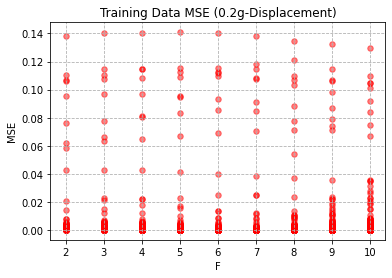

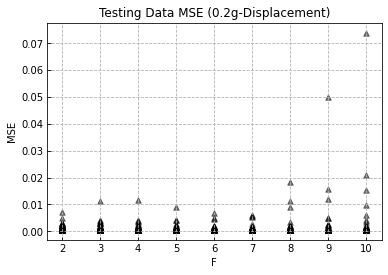

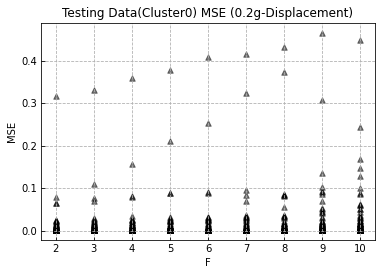

In [6]:
Train_MSE = MSE(y_Disp_train_stack,y_Disp_train_stack_pred)
Test_MSE = MSE(y_Disp_test_stack,y_Disp_test_stack_pred)
Test_MSE_c0 = MSE(y_Disp_test_stack_c0,y_Disp_test_c0_stack_pred)

## Normalized MSE
plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_MSE.shape[0])+i).astype(np.int8),Train_MSE[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
plt.title('Training Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Test_MSE.shape[0])+i).astype(np.int8),Test_MSE[:,i-1],s=30,c='black',marker='^',alpha=0.5,)
plt.title('Testing Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Test_MSE_c0.shape[0])+i).astype(np.int8),Test_MSE_c0[:,i-1],s=30,c='black',marker='^',alpha=0.5,)
plt.title('Testing Data(Cluster0) MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')



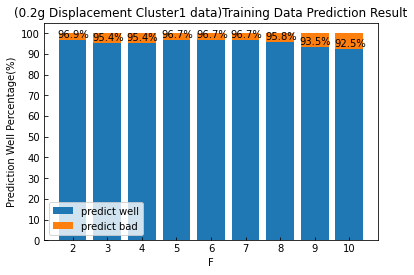

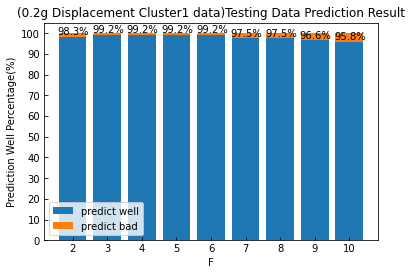

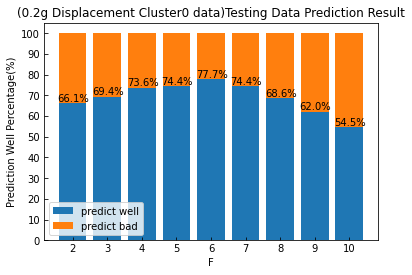

Training data: 382
Validation data: 96
Testing data: 119
Testing data(cluster0): 121


In [7]:
# 繪製MSE百分比圖
PerformanceIndex = 0.005

MSEList = [[Train_MSE,'(0.2g Displacement Cluster1 data)Training'],[Test_MSE,'(0.2g Displacement Cluster1 data)Testing'],[Test_MSE_c0,'(0.2g Displacement Cluster0 data)Testing']]
for sample in MSEList:  
  GoodList = []
  BadList = []
  for i in range(9):
    StoryMSE = sample[0][:,i]
    GoodData = StoryMSE[StoryMSE<=PerformanceIndex]
    GoodList.append(GoodData.shape[0]/StoryMSE.shape[0]*100)
    BadList.append(100 - GoodData.shape[0] / StoryMSE.shape[0]*100)

  x = np.arange(9)+2
  plt.figure()
  plt.bar(x, GoodList, label='predict well')
  plt.bar(x, BadList, bottom=GoodList,label='predict bad')
  for xy in zip(x, GoodList):
    plt.annotate("%.1f" %xy[1]+'%', xy=xy, xytext=(-15, 2), textcoords='offset points')
  plt.title(sample[1]+' Data Prediction Result')
  plt.xlabel('F')
  plt.ylabel('Prediction Well Percentage(%)')
  plt.xticks(x)
  plt.yticks(np.arange(0, 105, 10))
  plt.legend(loc = 'lower left') 
  plt.show()

print('Training data:',round(X_train_stack.shape[0]*0.8))
print('Validation data:',round(X_train_stack.shape[0]*0.2))
print('Testing data:',X_test_stack.shape[0])
print('Testing data(cluster0):',X_test_stack_c0.shape[0])


## Arrange index (bad to good)

In [8]:
top_Test = []
top_Train = []
top_C0=[]
for i in range(9):
  print('%d樓最大MSE Testing data index: '%(i+2),np.argmax(Test_MSE[:,i]))
  print('%d最大MSE Training data index: '%(i+2),np.argmax(Train_MSE[:,i]))
  
  sort_test = Test_MSE[:,i].copy()
  sort_test.sort()
  sort_train = Train_MSE[:,i].copy()
  sort_train.sort()
  sort_C0 = Test_MSE_c0[:,i].copy()
  sort_C0.sort()
  for j in range(1,sort_test.size+1):
    top_Test.append(np.where(Test_MSE[:,i]==sort_test[-j])[0][0])
  for k in range(1,sort_train.size+1):
    top_Train.append(np.where(Train_MSE[:,i]==sort_train[-k])[0][0])
  for k in range(1,sort_C0.size+1):
    top_C0.append(np.where(Test_MSE_c0[:,i]==sort_C0[-k])[0][0])

top_Test = np.array(top_Test).reshape(Test_MSE.shape[1],Test_MSE.shape[0])  #[樓層,資料數]
top_Train = np.array(top_Train).reshape(Train_MSE.shape[1],Train_MSE.shape[0])  #[樓層,資料數]
top_C0 = np.array(top_C0).reshape(Test_MSE_c0.shape[1],Test_MSE_c0.shape[0])  #[樓層,資料數]

2樓最大MSE Testing data index:  0
2最大MSE Training data index:  460
3樓最大MSE Testing data index:  0
3最大MSE Training data index:  460
4樓最大MSE Testing data index:  0
4最大MSE Training data index:  460
5樓最大MSE Testing data index:  0
5最大MSE Training data index:  460
6樓最大MSE Testing data index:  0
6最大MSE Training data index:  460
7樓最大MSE Testing data index:  6
7最大MSE Training data index:  460
8樓最大MSE Testing data index:  23
8最大MSE Training data index:  460
9樓最大MSE Testing data index:  23
9最大MSE Training data index:  460
10樓最大MSE Testing data index:  23
10最大MSE Training data index:  460


## Cluster1 Testing Data

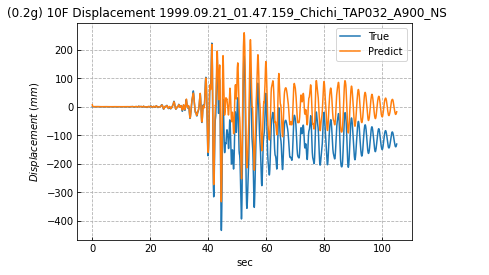

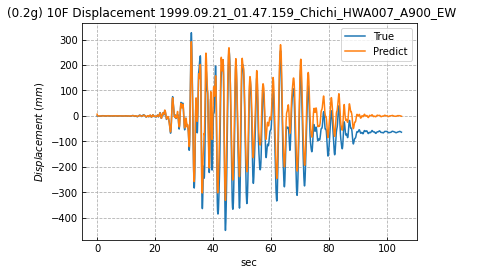

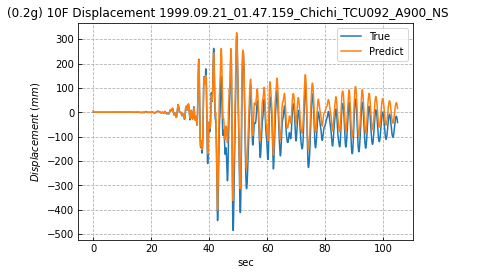

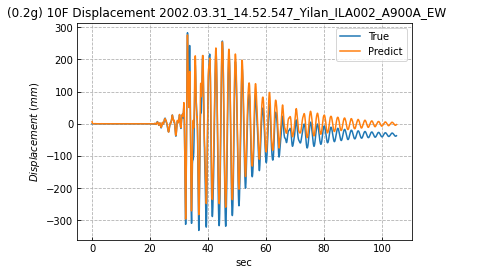

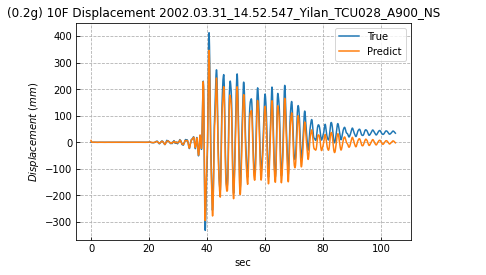

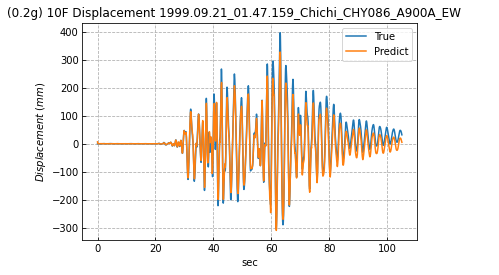

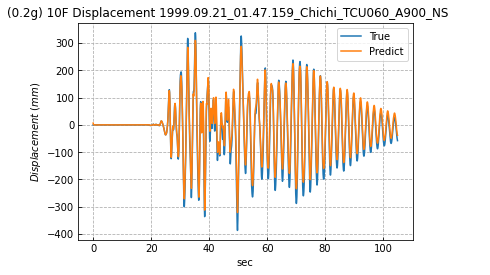

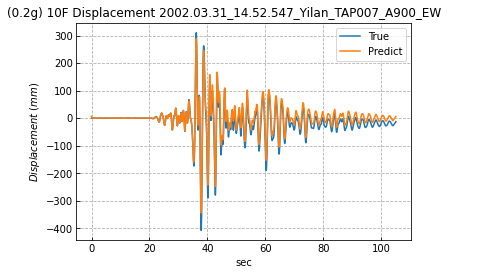

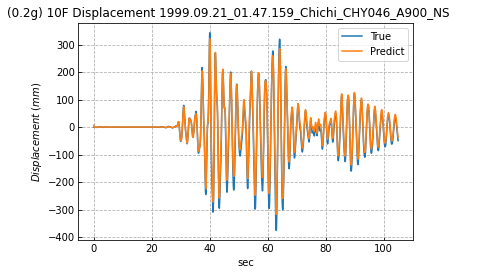

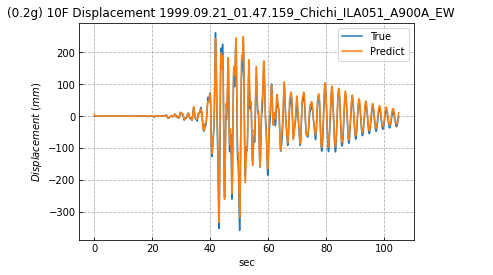

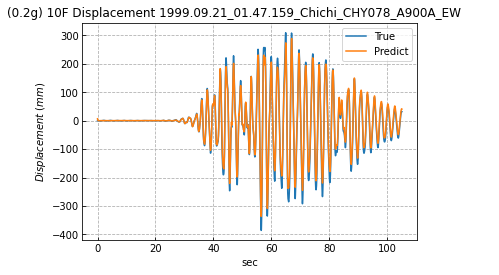

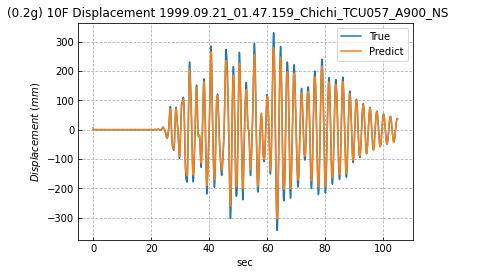

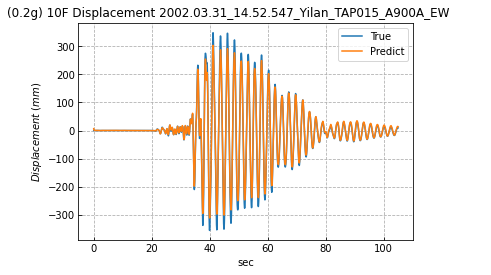

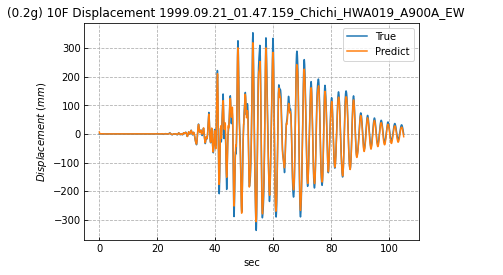

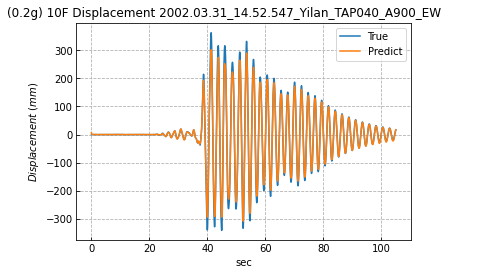

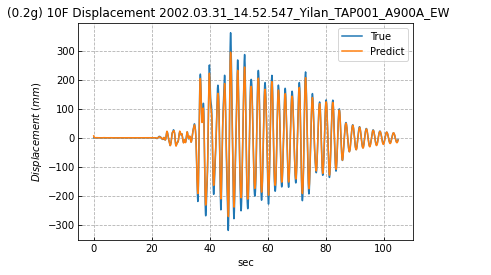

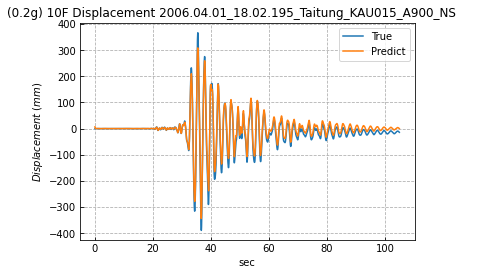

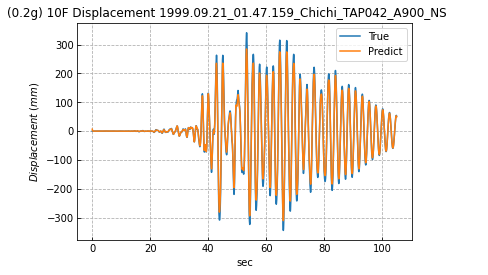

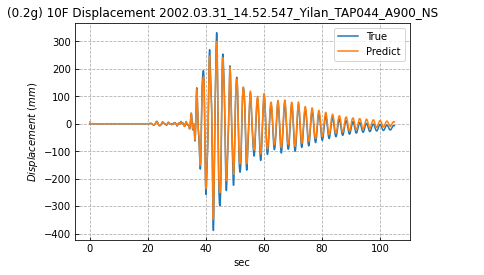

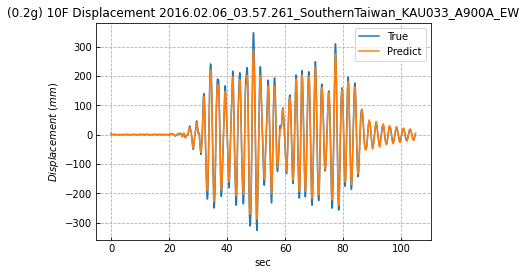

In [ ]:
#-------------------------------------------------------------------------------
# Plot testing 
F = 10  #(輸入待觀察樓層)
F = F-2
for sample in top_Test[F,0:20]:  #先看部分data
  plt.figure()
  plt.plot(np.linspace(0,105,2100), y_Disp_test_stack[sample][:, F], label='True')
  plt.plot(np.linspace(0,105,2100), y_Disp_test_stack_pred[sample][:, F], label='Predict')
  plt.title('(0.2g) %dF Displacement '%(F+2)+name_test[sample])
  plt.xlabel('sec')
  plt.ylabel('$Displacement\ (mm)$')
  plt.rcParams['xtick.direction'] = 'in'
  plt.rcParams['ytick.direction'] = 'in'
  plt.grid(linestyle='--')
  plt.legend()

## Cluster0 Data

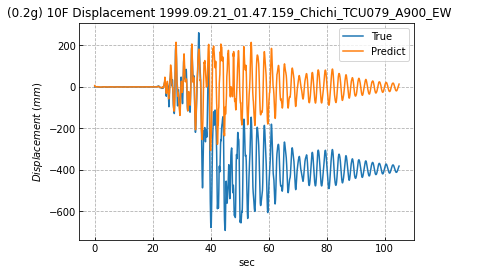

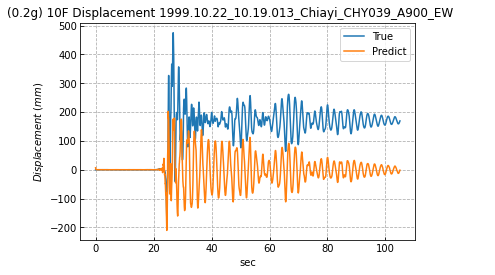

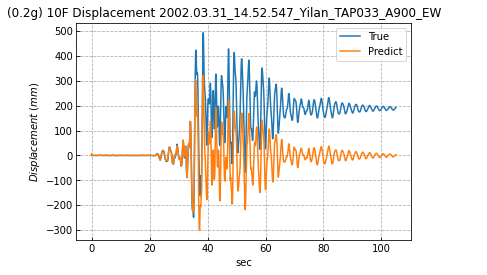

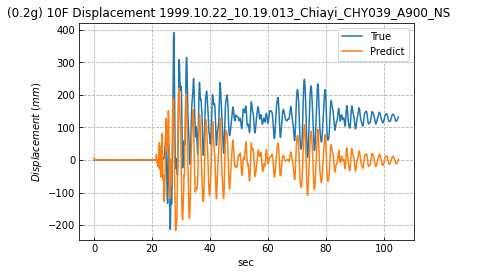

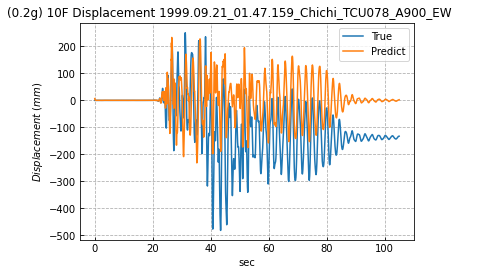

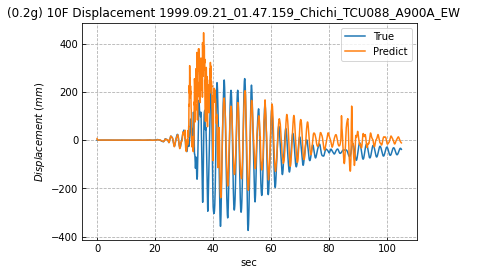

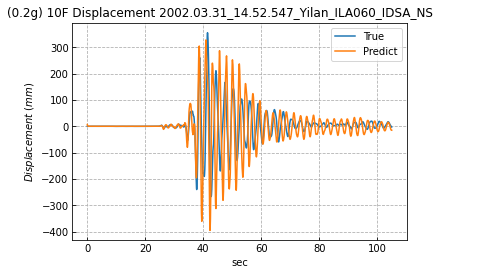

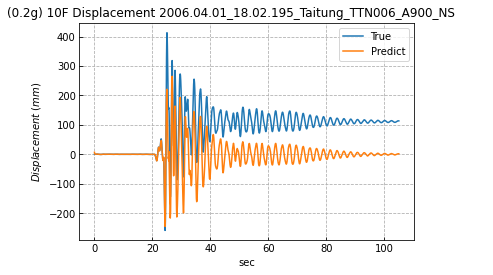

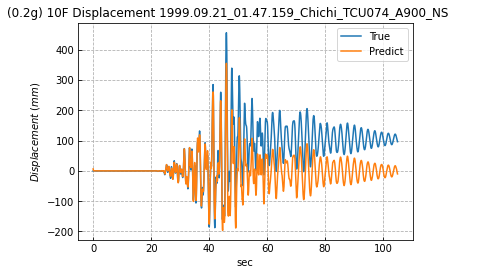

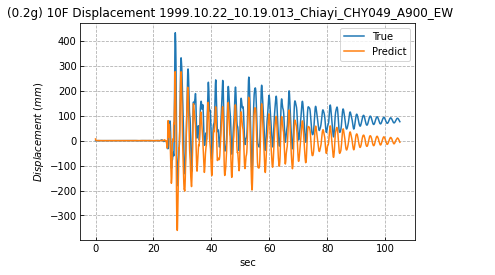

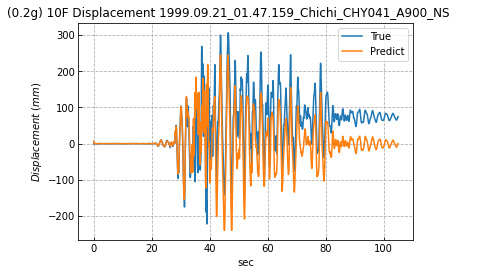

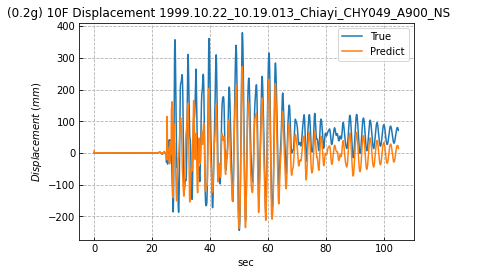

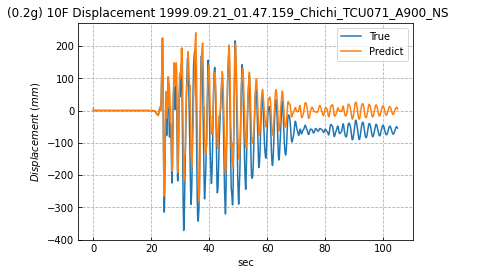

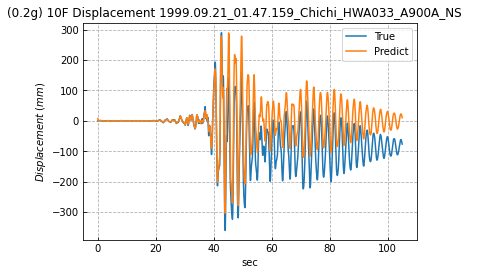

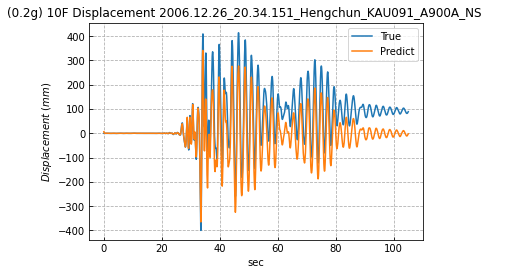

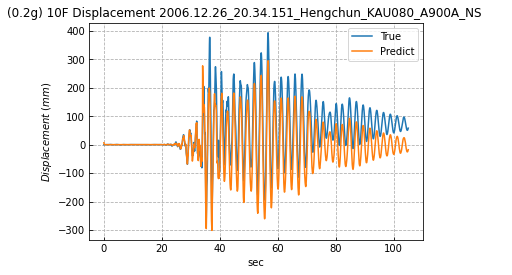

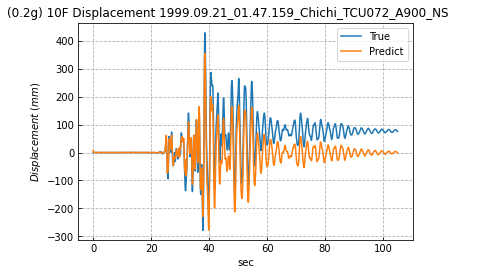

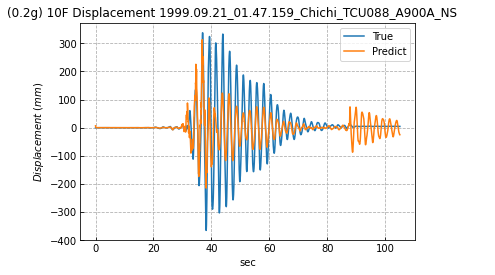

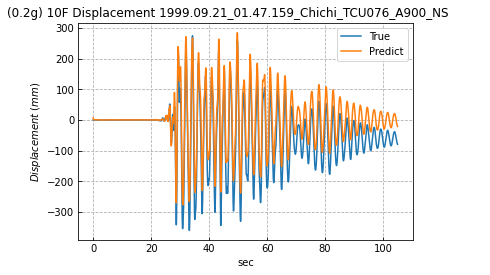

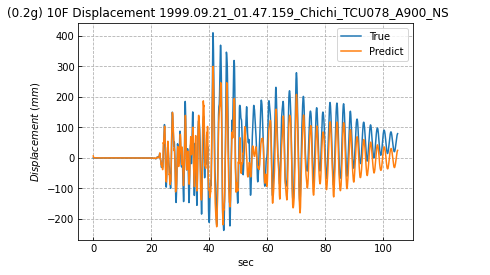

In [ ]:
#-------------------------------------------------------------------------------
# Plot C0 
F = 10  #(輸入待觀察樓層)
F = F-2
for sample in top_C0[F,0:20]:  #先看部分data
  plt.figure()
  plt.plot(np.linspace(0,105,2100), y_Disp_test_stack_c0[sample][:, F], label='True')
  plt.plot(np.linspace(0,105,2100), y_Disp_test_c0_stack_pred[sample][:, F], label='Predict')
  plt.title('(0.2g) %dF Displacement '%(F+2)+name_test_c0[sample])
  plt.xlabel('sec')
  plt.ylabel('$Displacement\ (mm)$')
  plt.rcParams['xtick.direction'] = 'in'
  plt.rcParams['ytick.direction'] = 'in'
  plt.grid(linestyle='--')
  plt.legend()

## Permanent Disp & Peak Disp

In [9]:
def Permanent_Disp(Displacement):
  PermanentDisp = []
  for i in range(Displacement.shape[0]):
    temp = Displacement[i][1800:-1,8]
    InexMax = np.argmax(temp)
    InexMin = np.argmin(temp)
    length = abs(InexMax-InexMin)
    AVG_nonlineraity = np.average(Displacement[i][-1-5*length:-1,8])
    PermanentDisp.append(AVG_nonlineraity)
  PermanentDisp = np.array(PermanentDisp)
  return PermanentDisp

Permanent_Disp_C1_test = Permanent_Disp(y_Disp_test_stack)
Permanent_Disp_C1_train = Permanent_Disp(y_Disp_train_stack)
Permanent_Disp_C0_test = Permanent_Disp(y_Disp_test_stack_c0)
Peak_Disp_C1_test = np.max(abs(y_Disp_test_stack[:,:,-1]),axis=1)
Peak_Disp_C1_train = np.max(abs(y_Disp_train_stack[:,:,-1]),axis=1)
Peak_Disp_C0_test = np.max(abs(y_Disp_test_stack_c0[:,:,-1]),axis=1)

"\nplt.figure()\nplt.scatter(Test_MSE[:,-1] ,Peak_Disp_C1_test,s=30,c='black',marker='^',alpha=0.5,label='cluster0-Testing Data')\nplt.scatter(Train_MSE[:,-1] ,Peak_Disp_C1_train,s=30,c='b',marker='^',alpha=0.5,label='cluster0-Training Data')\nplt.scatter(Test_MSE_c0[:,-1][Test_MSE_c0[:,-1]<0.02] ,Peak_Disp_C0_test[Test_MSE_c0[:,-1]<0.02] ,s=30,c='r',marker='o',alpha=0.5,label='cluster1')\nplt.title('Peak Displacement-MSE Scatter')\nplt.xlabel('Data number')\nplt.ylabel('Displacement(mm)')\nplt.rcParams['xtick.direction'] = 'in'\nplt.rcParams['ytick.direction'] = 'in'\nplt.legend(loc = 'lower left')\nplt.grid(linestyle='--')"

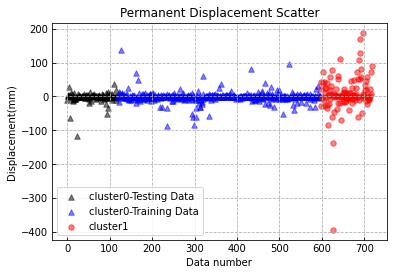

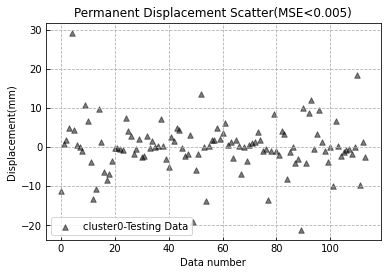

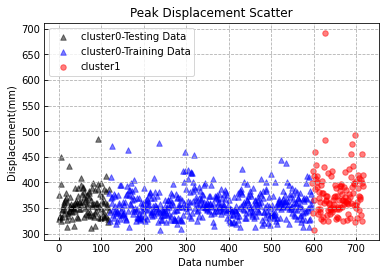

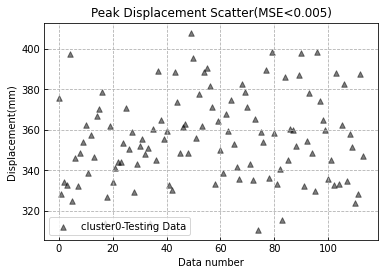

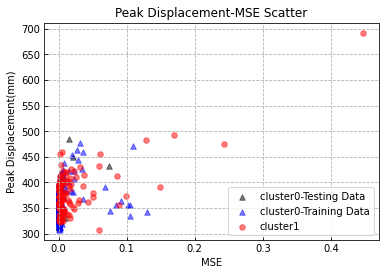

In [10]:
numer_C1_test = Permanent_Disp_C1_test.shape[0]
number_C1_train =  Permanent_Disp_C1_train.shape[0]
number_C0_test = Permanent_Disp_C0_test.shape[0]
## 永久位移
plt.figure()
plt.scatter(np.arange(numer_C1_test),Permanent_Disp_C1_test,s=30,c='black',marker='^',alpha=0.5,label='cluster0-Testing Data')
plt.scatter(np.arange(numer_C1_test,numer_C1_test+number_C1_train),Permanent_Disp_C1_train,s=30,c='b',marker='^',alpha=0.5,label='cluster0-Training Data')
plt.scatter(np.arange(numer_C1_test+number_C1_train,numer_C1_test+number_C1_train+number_C0_test),Permanent_Disp_C0_test,s=30,c='r',marker='o',alpha=0.5,label='cluster1')
plt.title('Permanent Displacement Scatter')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.legend(loc = 'lower left')
plt.grid(linestyle='--')

## MSE<0.005的永久位移
plt.figure()
plt.scatter(np.arange(Test_MSE[:,-1][Test_MSE[:,-1]<0.005].shape[0]),Permanent_Disp_C1_test[Test_MSE[:,-1]<0.005],s=30,c='black',marker='^',alpha=0.5,label='cluster0-Testing Data')
plt.title('Permanent Displacement Scatter(MSE<0.005)')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.legend(loc = 'lower left')
plt.grid(linestyle='--')

## 最大位移
plt.figure()
plt.scatter(np.arange(numer_C1_test),Peak_Disp_C1_test,s=30,c='black',marker='^',alpha=0.5,label='cluster0-Testing Data')
plt.scatter(np.arange(numer_C1_test,numer_C1_test+number_C1_train),Peak_Disp_C1_train,s=30,c='b',marker='^',alpha=0.5,label='cluster0-Training Data')
plt.scatter(np.arange(numer_C1_test+number_C1_train,numer_C1_test+number_C1_train+number_C0_test),Peak_Disp_C0_test,s=30,c='r',marker='o',alpha=0.5,label='cluster1')
plt.title('Peak Displacement Scatter')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.legend(loc = 'upper left')
plt.grid(linestyle='--')

## MSE<0.005的最大位移
plt.figure()
plt.scatter(np.arange(Test_MSE[:,-1][Test_MSE[:,-1]<0.005].shape[0]),Peak_Disp_C1_test[Test_MSE[:,-1]<0.005],s=30,c='black',marker='^',alpha=0.5,label='cluster0-Testing Data')
plt.title('Peak Displacement Scatter(MSE<0.005)')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.legend(loc = 'lower left')
plt.grid(linestyle='--')

# 最大位移-MSE
plt.figure()
plt.scatter(Test_MSE[:,-1] ,Peak_Disp_C1_test,s=30,c='black',marker='^',alpha=0.5,label='cluster0-Testing Data')
plt.scatter(Train_MSE[:,-1] ,Peak_Disp_C1_train,s=30,c='b',marker='^',alpha=0.5,label='cluster0-Training Data')
plt.scatter(Test_MSE_c0[:,-1] ,Peak_Disp_C0_test,s=30,c='r',marker='o',alpha=0.5,label='cluster1')
plt.title('Peak Displacement-MSE Scatter')
plt.xlabel('MSE')
plt.ylabel('Peak Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.legend(loc = 'lower right')
plt.grid(linestyle='--')

'''
plt.figure()
plt.scatter(Test_MSE[:,-1] ,Peak_Disp_C1_test,s=30,c='black',marker='^',alpha=0.5,label='cluster0-Testing Data')
plt.scatter(Train_MSE[:,-1] ,Peak_Disp_C1_train,s=30,c='b',marker='^',alpha=0.5,label='cluster0-Training Data')
plt.scatter(Test_MSE_c0[:,-1][Test_MSE_c0[:,-1]<0.02] ,Peak_Disp_C0_test[Test_MSE_c0[:,-1]<0.02] ,s=30,c='r',marker='o',alpha=0.5,label='cluster1')
plt.title('Peak Displacement-MSE Scatter')
plt.xlabel('Data number')
plt.ylabel('Displacement(mm)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.legend(loc = 'lower left')
plt.grid(linestyle='--')'''



## 觀察C0表現最差top20反應譜

No handles with labels found to put in legend.


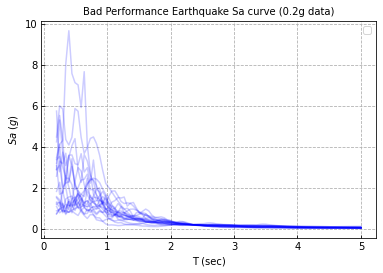

In [12]:
mat_BCSpectrum = scipy.io.loadmat(dataDir+'NewData_Disp_BC.mat')
BC_Spectrum = mat_BCSpectrum['BC_Spectrum']
label = mat_data['label'][0]

Bad_C0_Spectrum = BC_Spectrum[label==0][top_C0[-1,0:20]]

plt.figure()
for i in range(0,Bad_C0_Spectrum.shape[0]):
    plt.plot(np.linspace(0.2, 5, 100),Bad_C0_Spectrum[i]/9.8,"b-",alpha=0.2)
plt.title('Bad Performance Earthquake Sa curve (0.2g data)',fontsize=10)
plt.xlabel('T (sec)')
plt.ylabel('$Sa\ (g)$')
plt.grid(linestyle='--')
plt.legend(loc = 'upper right') 